In [2]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 69.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 127.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 122.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 23.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import cv2
import json
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch
from peft import PeftModel

# Loading Model and set into evaluating mode

In [2]:
# Model ID
local_cache = './qwen2.5_model/'
base_model_id = "Qwen/Qwen2.5-VL-7B-Instruct"

# Load processor (includes tokenizer + image processor)
processor = AutoProcessor.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    use_fast=False,
    cache_dir=local_cache
)

# Load model using AutoModelForVision2Seq
model = AutoModelForVision2Seq.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir=local_cache
)

# Set to evaluation mode
model.eval()


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Qwen2_5_VLForConditionalGeneration(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )
    )
    (merger): Qwen2_5_VLPatchMerger

In [4]:
!which python

/mnt/efs/garvit_data/LLM_Finetune/llm_venv/bin/python


In [5]:
!pwd

/mnt/efs/garvit_data/LLM_Finetune


# Loading and preparing Data 

In [3]:
# This function will give the tuples of the different groups of Data

def load_cigroupdata():
    """Load dataset of images and JSON annotations"""
    dirp = '/mnt/efs/RaghavWork/CIGroups'
    outsp = {}
    samples = 0

    for root, _, files in os.walk(dirp):
        for file in files:
            if file.endswith('.json'):
                continue
            key = os.path.basename(root)
            fullpath = os.path.join(root, file)
            fullpath_v2 = os.path.join(root, file + '_geo.json')

            if os.path.isfile(fullpath) and os.path.isfile(fullpath_v2):
                if key not in outsp:
                    outsp[key] = []
                outsp[key].append((fullpath, fullpath_v2))
                samples += 1

    datalist = [v for v in outsp.values() if len(v) >= 2]
    return datalist

In [4]:
print("size of the dataset is: ", len(load_cigroupdata()))

size of the dataset is:  169


In [5]:
sample = load_cigroupdata()

In [6]:
def get_image_and_jsongt(sample):
    """Extract OCR words and their bounding boxes from JSON"""
    img_path, json_path = sample
    
    with open(json_path, encoding="utf8") as f:
        json_data = json.load(f)
    
    word_boxes = []
    for clas in json_data['parse']['class']:
        items = json_data['parse']['class'][clas]
        for item in items:
            for wrd_id in item:
                word = json_data['words'][wrd_id]['text']
                bbox = json_data['words'][wrd_id]['boundingBox'][0] + json_data['words'][wrd_id]['boundingBox'][2]
                rlabel = json_data['words'][wrd_id].get('row_label', [0])[0]
                word_boxes.append((bbox, word, clas, rlabel))
    
    return img_path, word_boxes

In [7]:
def sort_ocr_by_position(bbox_list):
    """
    Sort bounding boxes from left to right and then top to bottom.
    
    Parameters:
    - bbox_list: List of tuples where each tuple contains a bounding box in the format:
      ([left, top, right, bottom], text, category, flag)
    - y_tolerance: A small threshold to consider bounding boxes in the same line

    Returns:
    - Sorted list of bounding boxes.
    """
    # First, sort by top (y) coordinate, then by left (x) coordinate
    sorted_bbox_list = sorted(bbox_list, key=lambda x: (x[0][1], x[0][0]))
    
    return sorted_bbox_list

In [8]:
def get_final_xml(sample):
    """
    Build XML preserving the exact visual reading order from sample.
    Groups words into fields by class label and row, appending in sequence.
    """
    from collections import defaultdict

    key_values = defaultdict(list)
    line_items = defaultdict(lambda: defaultdict(list))
    ocr_text = ""

    for bx, word, cls, row in sample:
        word = word.strip()
        if not word:
            continue
        ocr_text = ocr_text + " " + word
        if row == 0 and cls.endswith('_VALUE'):
            key_values[cls].append(word)
        elif cls.endswith('_VALUE') and 'MISC' not in cls:
            row = str(row)
            line_items[row][cls].append(word)
    xml_parts = []

    # Add key-values
    for cls, words in key_values.items():
        tag = cls.lower().replace('_value', '')
        xml_parts.append(f"<s_{tag}>{' '.join(words)}</s_{tag}>")

    # Add line-items preserving order from sample
    for row in sorted(line_items.keys(), key=int):
        fields = line_items[row]
        if len(fields) < 3:
            continue  # Skip incomplete lines
        xml_parts.append("<s_line>")

        for cls in fields:
            tag = cls.lower().replace('_value', '')
            content = ' '.join(fields[cls])
            if tag == 'unit_price':
                content = content.replace(',', '.').replace('/', '').replace('ST', '1.00').strip()

            xml_parts.append(f"<s_{tag}>{content}</s_{tag}>")

        xml_parts.append("</s_line>")

    return ''.join(xml_parts), ocr_text.strip()

# One Shot prompting

In [9]:
img_path_0, word_boxes_0 = get_image_and_jsongt(sample[12][0])
sorted_ocr_0 = sort_ocr_by_position(word_boxes_0)
gt_xml_0, ocr_text_0 = get_final_xml(sorted_ocr_0)  
image_0 = Image.open(img_path_0).convert("RGB").resize((800, 800))

In [10]:
print(ocr_text_0)

FALKEN * INVOICE * SUMITOMO RUBBER INDUSTRIES.LTD . TOYOSU CENTER BUILDING 2nd weekly order - May . 2024 3-3,3 - CHOME , TOYOSU KOTO - KU , : YOUR REF NO TOKYO 135-6005 , JAPAN TEL : ( 03 ) 5546-0124 FAX : ( 03 ) 5546-0146 EET240598363 : INVOICE NO IRR L / C NO : L / C ISSUING DATE : BY ISSUED TOKYO I / V ISSUE PLACE : MAY.17,2024 . : ISSUE DATE 【 ATTACHED SHEET 】 3 Page AMOUNT DESCRIPTION OF GOODS UNIT UNIT PRICE SRNA CODE QUANTITY Tariff 4011.10.1040 4.0 % TSUSA NO . : rate : Brand FALKEN : order - 2nd 2024 weekly May . REF NO : 0 36 US $ US $ 1,887.48 205 / 55R16 91H SN250AS 52.43 28291483 324126 205 / 65R16 95H SN250AS 55.58 3,779.44 68 324117 28291626 54.53 205 / 60R16 92H SN250AS с 4,471.46 28291652 82 324121 215 / 70R16 100T SN250AS 52 64.47 3,352.44 28294100 324114 101 205 / 55R16 91T SN250AS 51.93 5,244.93 28294483 324127 195 / 55R16 87T SN250AS 324078 16 49.11 785.76 28294615 215 / 65R16 102V CT60AS XL C 9 62.57 563.13 28042275 329009 67.16 235 / 60R16 100H SN250AS 28291655 C

This is the example ground truth JSON: 
<s_invoice_number>EET240598363 :</s_invoice_number><s_hts_number>4011.10.1040</s_hts_number><s_line><s_quantity>36</s_quantity><s_line_item_total>1,887.48</s_line_item_total><s_product_description>205 / 55R16 91H SN250AS 324126</s_product_description><s_unit_price>52.43</s_unit_price><s_sku>28291483</s_sku></s_line><s_line><s_product_description>205 / 65R16 95H SN250AS 324117</s_product_description><s_unit_price>55.58</s_unit_price><s_line_item_total>3,779.44</s_line_item_total><s_quantity>68</s_quantity><s_sku>28291626</s_sku></s_line><s_line><s_unit_price>54.53</s_unit_price><s_product_description>205 / 60R16 92H SN250AS 324121</s_product_description><s_line_item_total>4,471.46</s_line_item_total><s_sku>28291652</s_sku><s_quantity>82</s_quantity></s_line><s_line><s_product_description>215 / 70R16 100T SN250AS 324114</s_product_description><s_quantity>52</s_quantity><s_unit_price>64.47</s_unit_price><s_line_item_total>3,352.44</s_line_item_total

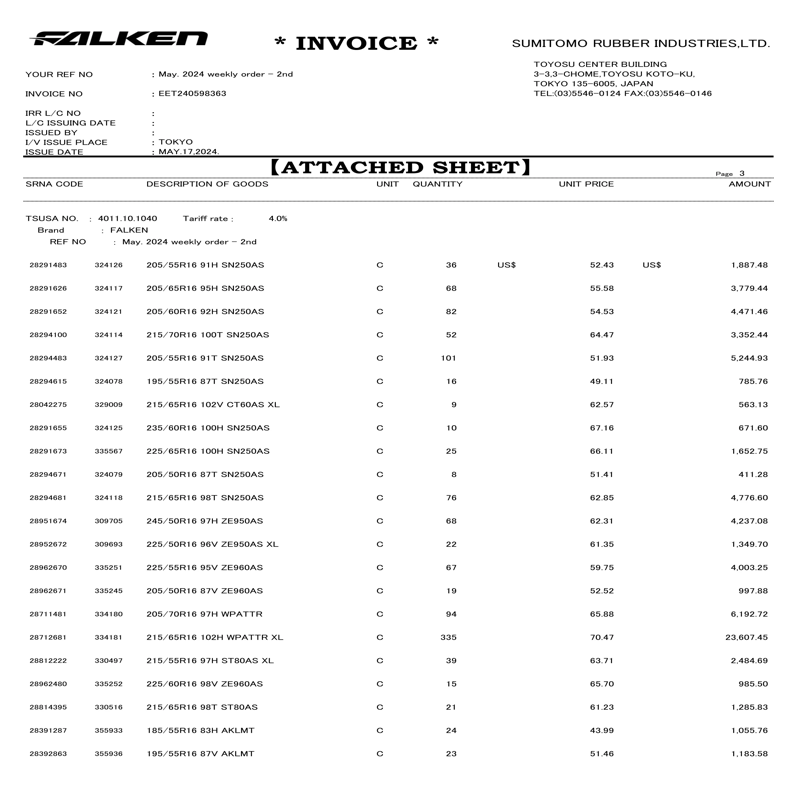

In [11]:
print("This is the example ground truth JSON: ")
print(gt_xml_0)

print("This is the example image: ")
print()
image_0

In [12]:
# Step 2: Load sample[1] (Inference example)
img_path_1, word_boxes_1 = get_image_and_jsongt(sample[12][1])
sorted_ocr_1 = sort_ocr_by_position(word_boxes_1)
gt_xml_1, ocr_text_1 = get_final_xml(sorted_ocr_1)
image_1 = Image.open(img_path_1).convert("RGB").resize((800, 800))

# Step 3: Construct prompt
prompt = [
    {
        "role": "user",
        "content": [
            {"type": "image"},  # Example image (image_0 will be passed to the model separately)
            {
                "type": "text",
                "text": (
                    "This is an example invoice image.\n"
                    "Below is the OCR extracted text from this image:\n\n"
                    f"{ocr_text_0}\n\n"
                    "Based on this invoice and OCR, the correct structured XML is:\n\n"
                    f"{gt_xml_0}\n\n"
                    "Learn from this format, structure, and tagging."
                )
            }
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},  # Inference image (image_1 will be passed to the model separately)
            {
                "type": "text",
                "text": (
                    "Now analyze this new invoice image.\n"
                    "Here is the OCR extracted text for this image:\n\n"
                    f"{ocr_text_1}\n\n"
                    "Based on the invoice and the OCR, generate the structured XML output following the same tags and structure as shown in the example above.\n\n"
                    "You must perform exceptionally well on invoices of varying formats, layouts, and languages.\n\n"
                    "Use the following template to guide your structure:\n"
                    "<s_invoice_date></s_invoice_date>\n"
                    "<s_invoice_number></s_invoice_number>\n"
                    "<s_invoice_total></s_invoice_total>\n"
                    "<s_po_number></s_po_number>\n"
                    "<s_line>\n"
                    "    <s_quantity></s_quantity>\n"
                    "    <s_product_description></s_product_description>\n"
                    "    <s_unit_price></s_unit_price>\n"
                    "    <s_origin_country></s_origin_country>\n"
                    "    <s_line_item_total></s_line_item_total>\n"
                    "</s_line>"
                )
            }
        ]
    }
]

This is the inference image: 


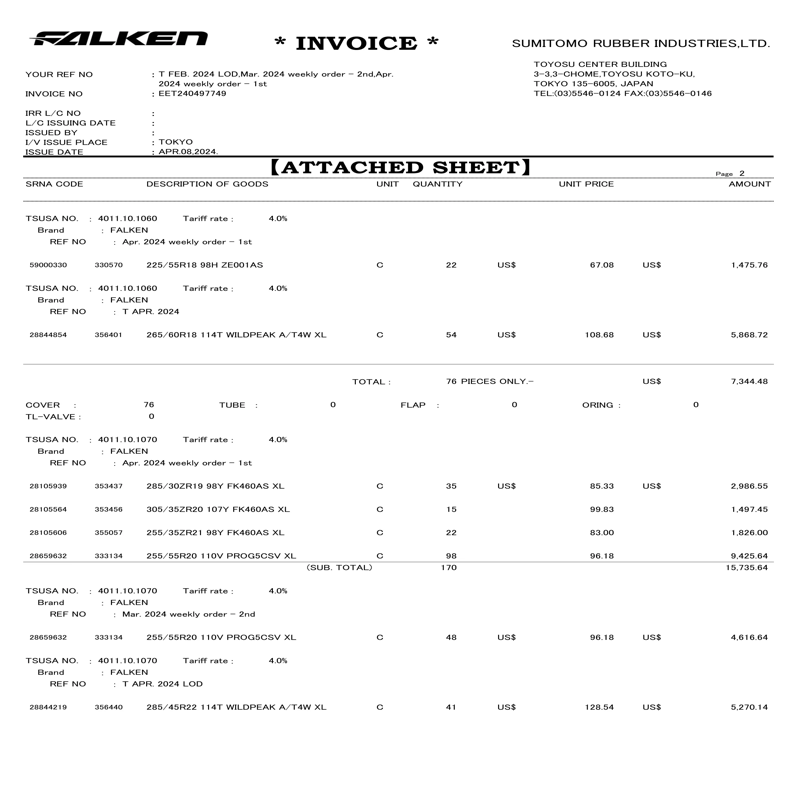

In [13]:
print("This is the inference image: ")
image_1

# This is just for view original resolution of inference image

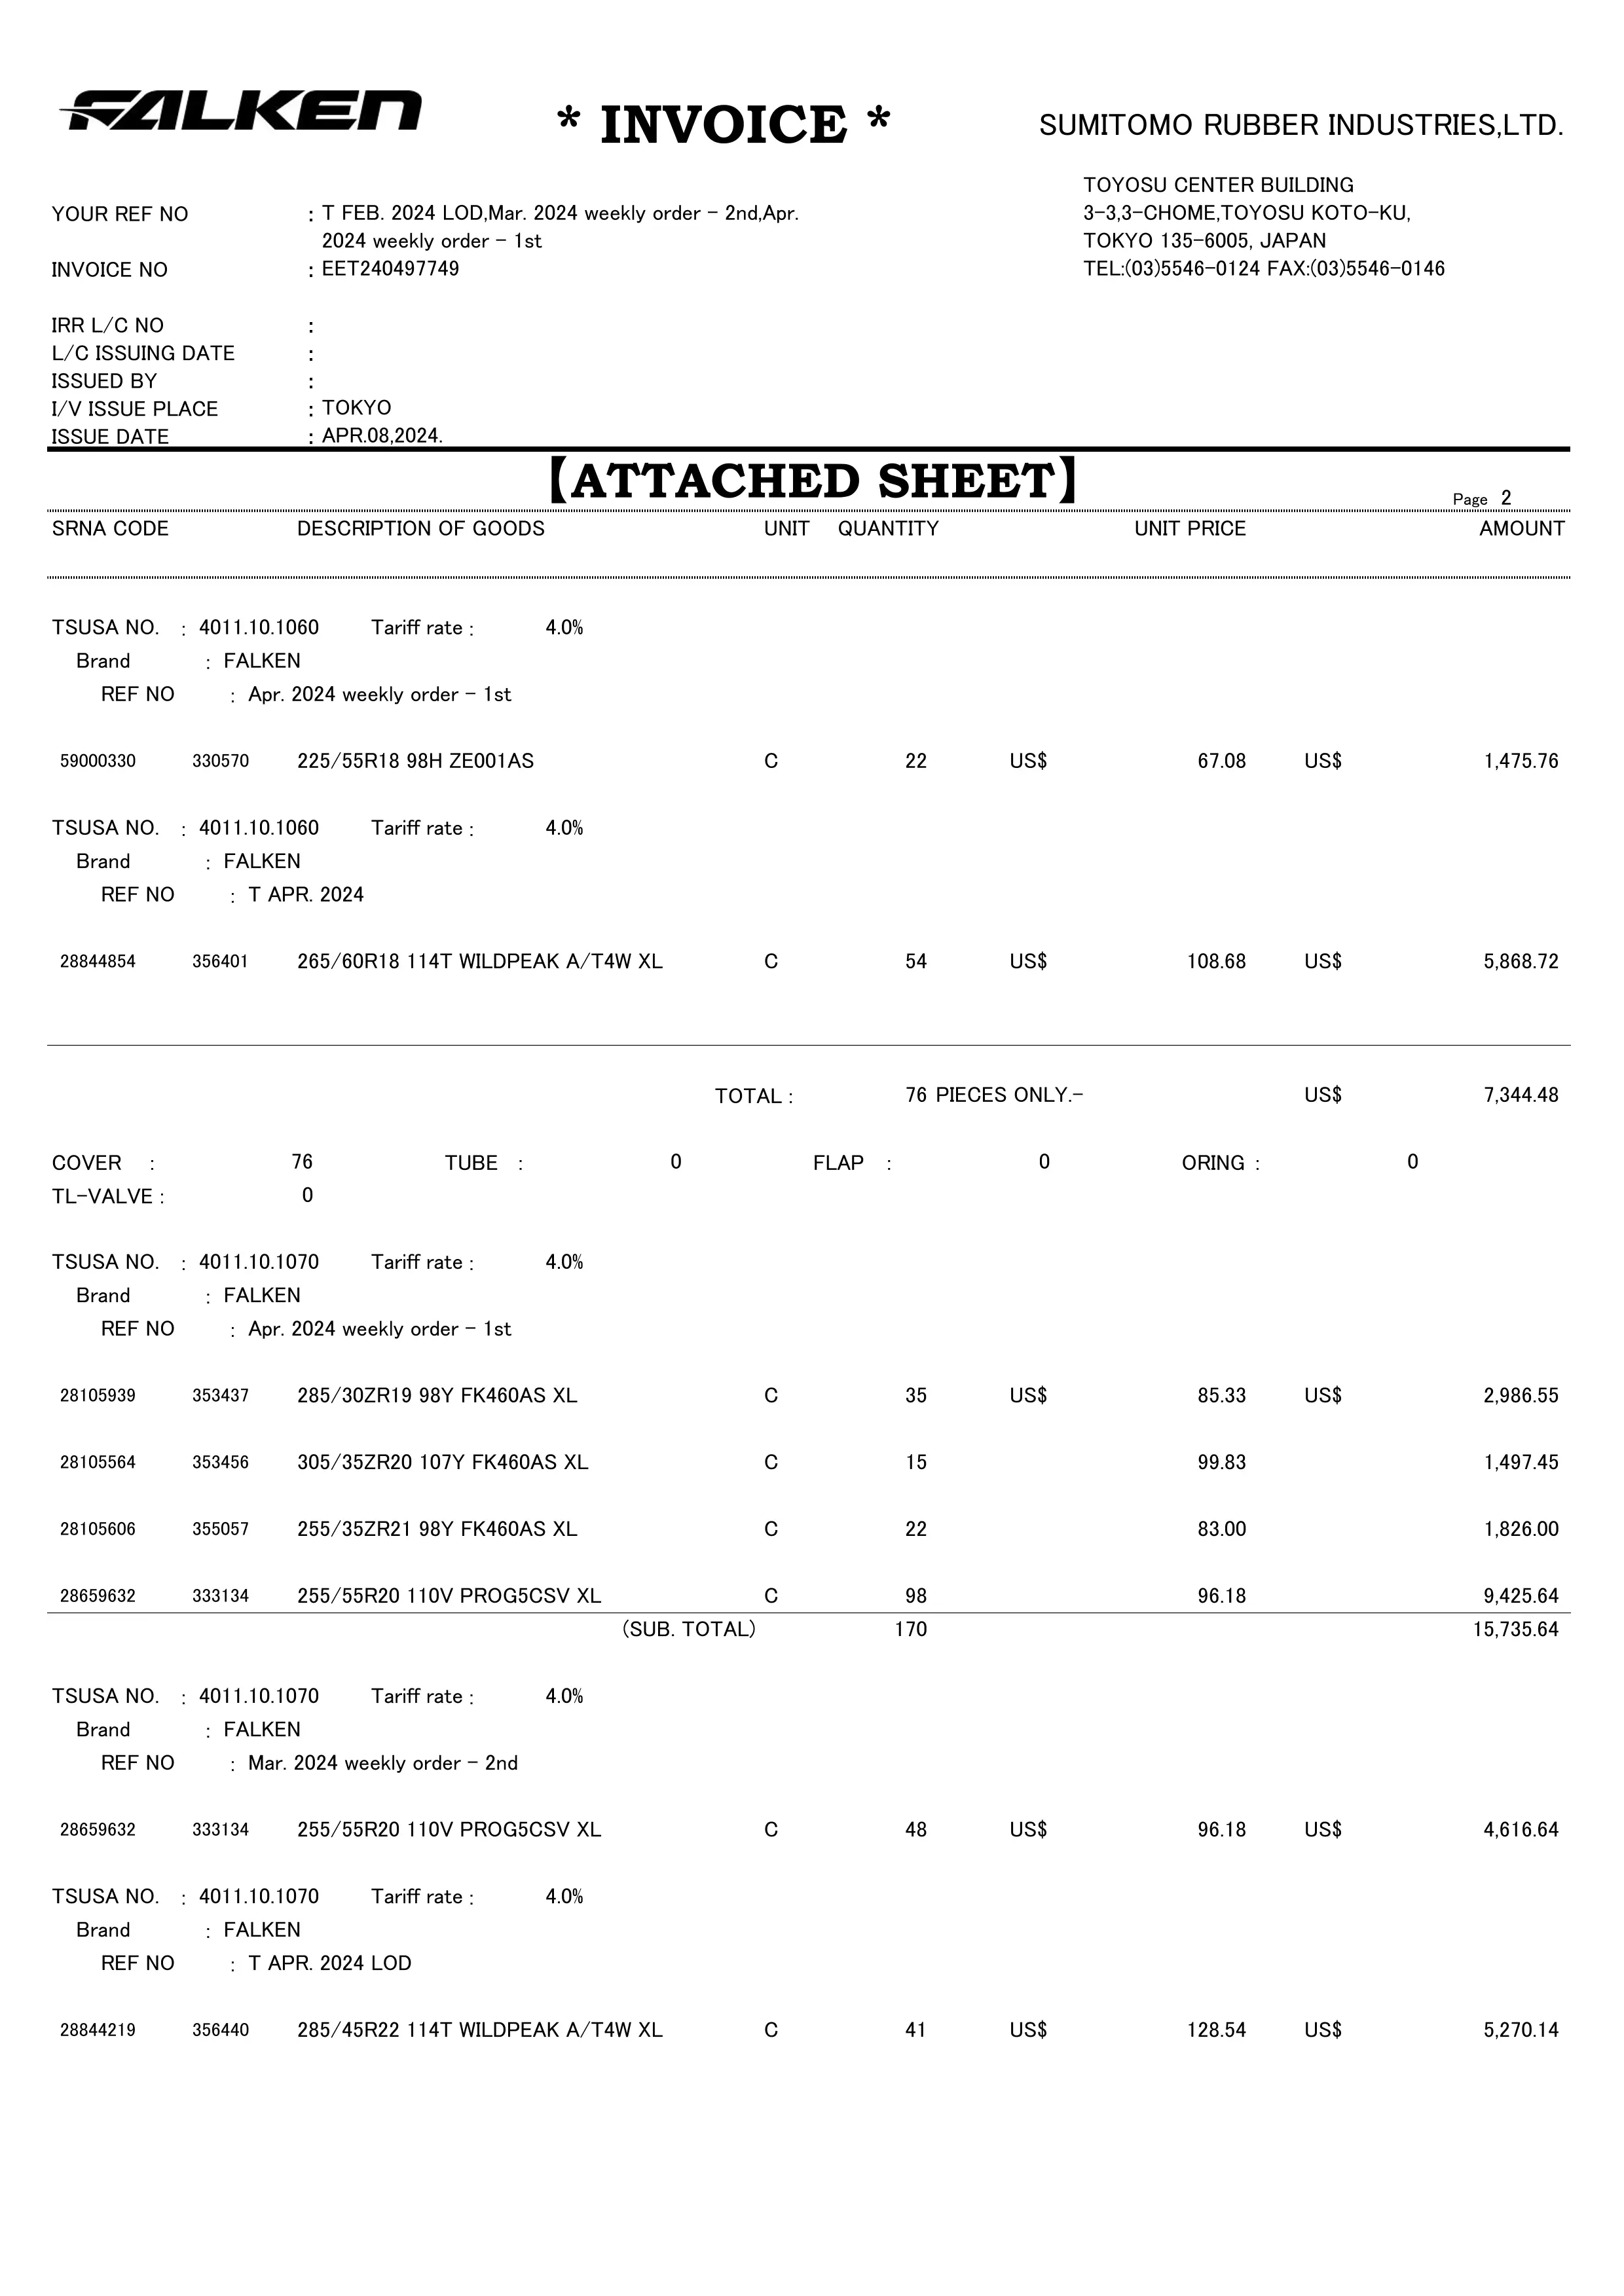

In [14]:
from IPython.display import Image, display
import shutil
# Display
display(Image(filename=img_path_1))

# Copy it to download with a simpler name
# shutil.copy(img_path_1, "oneshot-image-4.jpg")


# Generation of output using one shot from Qwen2

In [15]:
# Step 4: Apply prompt template
formatted_prompt = processor.apply_chat_template(prompt, add_generation_prompt=True)

# Step 5: Tokenize and move to device
inputs = processor(text=formatted_prompt, images=[image_0, image_1], return_tensors="pt").to(model.device)

# Step 6: Generate XML output
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=2048,
        temperature=0.1,
        top_p=0.9
    )

# Step 7: Decode model output
response = processor.tokenizer.batch_decode(output, skip_special_tokens=True)[0]
print(response.strip())
print()
print("This should be the output of inference image: ", gt_xml_1)

system
You are a helpful assistant.
user
This is an example invoice image.
Below is the OCR extracted text from this image:

FALKEN * INVOICE * SUMITOMO RUBBER INDUSTRIES.LTD . TOYOSU CENTER BUILDING 2nd weekly order - May . 2024 3-3,3 - CHOME , TOYOSU KOTO - KU , : YOUR REF NO TOKYO 135-6005 , JAPAN TEL : ( 03 ) 5546-0124 FAX : ( 03 ) 5546-0146 EET240598363 : INVOICE NO IRR L / C NO : L / C ISSUING DATE : BY ISSUED TOKYO I / V ISSUE PLACE : MAY.17,2024 . : ISSUE DATE 【 ATTACHED SHEET 】 3 Page AMOUNT DESCRIPTION OF GOODS UNIT UNIT PRICE SRNA CODE QUANTITY Tariff 4011.10.1040 4.0 % TSUSA NO . : rate : Brand FALKEN : order - 2nd 2024 weekly May . REF NO : 0 36 US $ US $ 1,887.48 205 / 55R16 91H SN250AS 52.43 28291483 324126 205 / 65R16 95H SN250AS 55.58 3,779.44 68 324117 28291626 54.53 205 / 60R16 92H SN250AS с 4,471.46 28291652 82 324121 215 / 70R16 100T SN250AS 52 64.47 3,352.44 28294100 324114 101 205 / 55R16 91T SN250AS 51.93 5,244.93 28294483 324127 195 / 55R16 87T SN250AS 324078 1

# Test for complex examples from prod

In [14]:
def print_gpu_memory_usage(label=""):
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)  # in MB
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)    # in MB
        print(f"[{label}] Allocated: {allocated:.2f} MB | Reserved: {reserved:.2f} MB")

In [31]:
json_0 = {
    "invoiceData": [
    {
      "invoiceNumber": "VRGP165780",
      "invoiceDate": "23.04.2025",
      "lineItem": [
        {
          "SKU": "6102394",
          "lineItemTotal": "3.130,08",
          "originCountry": "DE",
          "quantity": "24",
          "htsNumber": "8539 49 00",
          "productDescription": "UV - Lamp ECORAY ELR 30",
          "unitPrice": "130,42",
        }
      ]
    }
  ]
}

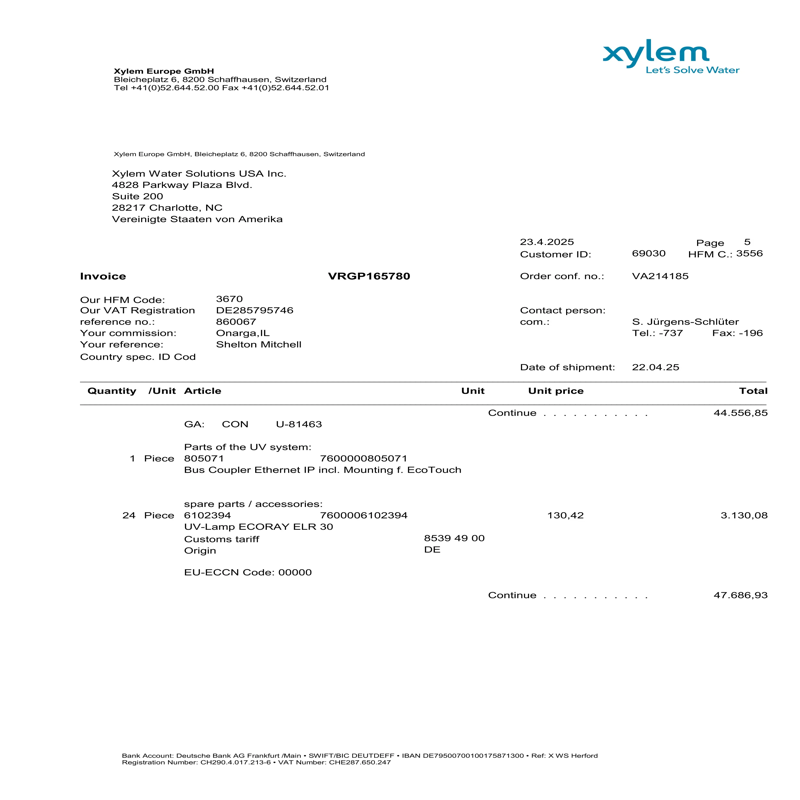

In [39]:
from IPython.display import Image, display
from PIL import Image

image_p_1 = "./given_images/xylem_water_solution_1_6rTbIB3J17hNnxW6uiV7.webp"
# display(Image(filename=image_p))
image_0 = Image.open(image_p_1).convert("RGB").resize((800, 800))
image_0

In [33]:
ocr_text_0 = """
: Complete package on about 250218
: CIF NET FROM SHANGHAI PORT TO DETROIT, MI
: 30 days from this date
FU SAN VALVE (DONG TAI) CO., LTD
NO. 8 FUYUAN ROAD, FU'AN TOWN DONGTAI CITY, JIANGSU PROVINCE, CHINA 224222
TEL 86-515-85578990 FAX 86-515-85578660 EMAIL fschina@fusan. com. tw
COMMERCIAL INVOICE
M/S. LEGEND VALVE & FITTING, INC. (10046)
We have pleasure in quoting you the commodity specified below on the terms and conditions
as follows:
Terms of Payment By wire transfer
Time of Delivery
Point of Delivery: SHANGHAI PORT
Destination
Containers/Packing: By standard export carton
Validity
DATE: 2025. 01. 10
NO: ZB24226A
Description of Goods.
Quantity
Price
Amount
P/0#28273
(NL1191Y) CAST BRASS Y-STRAINER 200PSI-NO LEAD
105-703NL
1/2"
64PCS
US$
3.94
USD
252.16
(NL1191Y) CAST BRASS Y-STRAINER 200PSI-NO LEAD
105-704NL
3/4"
192PCS
5.59
1,073. 28
(NL1191Y) CAST BRASS Y-STRAINER 200PSI-NO LEAD
105-705NL
105-707NL
105-708NL
1"
1-1/2"
2"
120PCS
8.55
1,026.00
24PCS
16.74
401.76
24PCS
29.07
697.68
T503 107-116NL (NL1171A) ANGLE STOP VALVE IPS 125 WOG-NO LEAD
107-116NL
1/2"
400 PCS
3.12
1,248.00
S521P (NL1171BP) BRASS BOILER DRAIN MALE WITH PEX CONNECTION 125 WOG-NO LEAD
107-159NL
1/2"
700PCS
3. 81
2,667.00
T531 (NL1171HB) BRASS HOSE BIBBS 125 WOG-NO LEAD
107-164NL
1/2"
100PCS
2. 34
234.00
T531 107-165NL (NL1171HB) BRASS HOSE BIBBS 125 WOG-NO LEAD
107-165NL
3/4"
400 PCS
2.62
1,048.00
NL 1331DARNQ-RB Dual handle Angel supply stop
114-630NL
3/8" COMP X 1/4" COMP X
600PCS
5.74
3, 444.00
NL1331DARN-RB Dual handle Angel supply stop-Rough Brass
114-631NL
3/8" COMP X 3/8" COMP X
800PCS
5.74
4,592.00
(NL1331DARP-RB) Dual handle Angel supply stop-Rough Brass
114-632NL
3/8" RN X 3/8″RN X 1/2" PEX
500PCS
6.34
3, 170.00
NL1331DSRN-RB Dual handle Straight supply stop-Rough Brass
114-731NL
3/8" COMP X 3/8" COMP X
700PCS
5.67
3,969.00
(NL1331DSRP-1/2W-RB) Dual handle Straight supply stop-Rough Brass
114-734NL
3/8" RN X 3/8″RN X 1/2 F1960
100PCS
6.59
659.00
T595 114-903NL (NL1331APF) ANGLE PUSH FIT BALL TYPE CHROME SUPPLY STOP-NO LEAD
114-903NL
1/2" PUSH FIT X 3/8" COMP
120PCS
3. 23
387.60
1/2" PUSH FIT X 3/8" COMP
T596 114-913NL (NL1331SPF) STRAIGHT PUSH FIT BALL TYPE CHROME SUPPLY STOP-NO LEAD
114-913NL
240PCS
3. 14
753.60
302-223 (F1173E) DROP EAR ELBOW FXC
302-223
1/2"CX1/2"F
2,100PCS
0.96
2,016.00
302-225NL (NL1173EC) DROP EAR ELBOW CXC-NO LEAD
302-225NL
1/2" CXC
1,800PCS
1.09
1,962.00
302-253NL (NL1173ECT) ELBOW WITH TAP CXC-NO LEAD
302-253NL
3/4C X 1/8F X 3/4C
600PCS
1.41
846.00
(NL1372UM) NL Brass
Solder Union
302-306LNL
1/2" CXM
400PCS
2.92
1, 168.00
302-308LNL
1" CXM
108-138F
302-308LNL (NL1372UM) NL Brass Solder Union
108-138 NEW&OLD TYPE V. B. REPAIR KIT P/N 10, 11, 12-1, 12-2, 14 FOR 2264
P/N 10, 11, 12-1, 12-2, 14
60PCS
5.80
348.00
1, 374PCS
1. 33
1,827.42
FSE801-1
ZB24226A
PAGE
1
"""

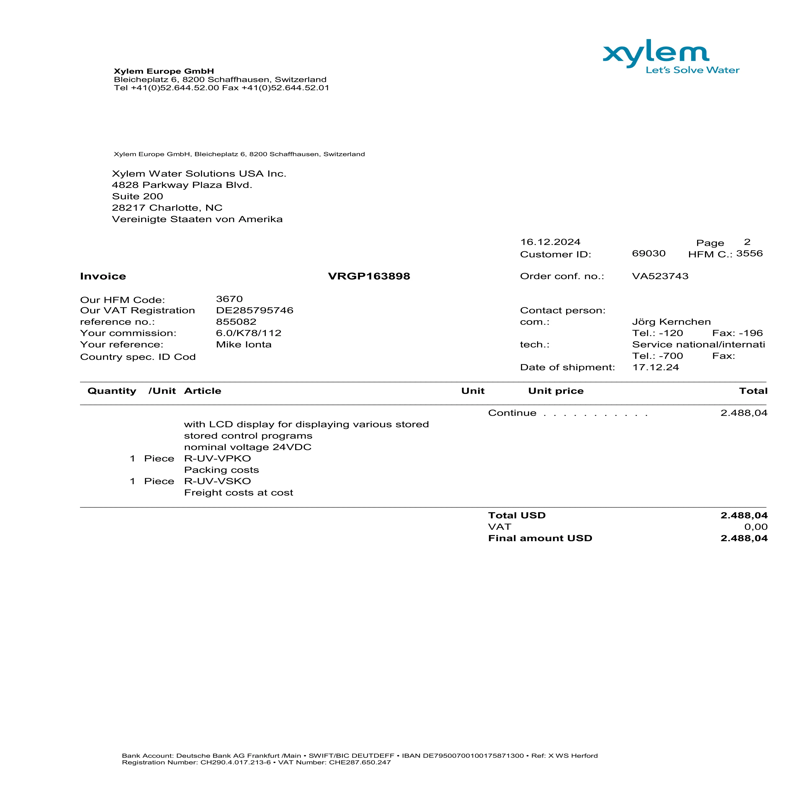

In [40]:
inference_image = "./inference_images/xylem_water_solution_1_yDmvhPVD4JZ8ypwK2Tqd.webp"
# display(Image(filename=inference_image))
image_1 = Image.open(inference_image).convert("RGB").resize((800, 800))
image_1

In [ ]:
{
  "invoiceData": [
    {
      "invoiceNumber": "VRGP163898",
      "invoiceDate": "16.12.2024",
      "lineItem": [
        {
          "SKU": "R-UV-VPKO",
          "lineItemTotal": "2.488,04",
          "originCountry": "DE",
          "quantity": "1",
          "htsNumber": "",
          "productDescription": "with LCD display for displaying various stored stored control programs nominal voltage 24VDC",
          "unitPrice": ""
        },
        {
          "SKU": "R-UV-VSKO",
          "lineItemTotal": "0,00",
          "originCountry": "DE",
          "quantity": "1",
          "htsNumber": "",
          "productDescription": "Packing costs",
          "unitPrice": ""
        }
      ]
    }
  ]
}

In [35]:
ocr_text_1 = """
: Complete package on about 250218
: CIF NET FROM SHANGHAI PORT TO DETROIT, MI
: 30 days from this date
FU SAN VALVE (DONG TAI) CO., LTD
NO. 8 FUYUAN ROAD, FU'AN TOWN DONGTAI CITY, JIANGSU PROVINCE, CHINA 224222
TEL 86-515-85578990 FAX 86-515-85578660 EMAIL fschina@fusan. com. tw
COMMERCIAL INVOICE
M/S. LEGEND VALVE & FITTING, INC. (10046)
We have pleasure in quoting you the commodity specified below on the terms and conditions
as follows:
Terms of Payment By wire transfer
Time of Delivery
Point of Delivery: SHANGHAI PORT
Destination
Containers/Packing: By standard export carton
Validity
DATE: 2025. 01. 10
NO: ZB24226A
Description of Goods.
Quantity
Price
Amount
P/0#28273
(NL1191Y) CAST BRASS Y-STRAINER 200PSI-NO LEAD
105-703NL
1/2"
64PCS
US$
3.94
USD
252.16
(NL1191Y) CAST BRASS Y-STRAINER 200PSI-NO LEAD
105-704NL
3/4"
192PCS
5.59
1,073. 28
(NL1191Y) CAST BRASS Y-STRAINER 200PSI-NO LEAD
105-705NL
105-707NL
105-708NL
1"
1-1/2"
2"
120PCS
8.55
1,026.00
24PCS
16.74
401.76
24PCS
29.07
697.68
T503 107-116NL (NL1171A) ANGLE STOP VALVE IPS 125 WOG-NO LEAD
107-116NL
1/2"
400 PCS
3.12
1,248.00
S521P (NL1171BP) BRASS BOILER DRAIN MALE WITH PEX CONNECTION 125 WOG-NO LEAD
107-159NL
1/2"
700PCS
3. 81
2,667.00
T531 (NL1171HB) BRASS HOSE BIBBS 125 WOG-NO LEAD
107-164NL
1/2"
100PCS
2. 34
234.00
T531 107-165NL (NL1171HB) BRASS HOSE BIBBS 125 WOG-NO LEAD
107-165NL
3/4"
400 PCS
2.62
1,048.00
NL 1331DARNQ-RB Dual handle Angel supply stop
114-630NL
3/8" COMP X 1/4" COMP X
600PCS
5.74
3, 444.00
NL1331DARN-RB Dual handle Angel supply stop-Rough Brass
114-631NL
3/8" COMP X 3/8" COMP X
800PCS
5.74
4,592.00
(NL1331DARP-RB) Dual handle Angel supply stop-Rough Brass
114-632NL
3/8" RN X 3/8″RN X 1/2" PEX
500PCS
6.34
3, 170.00
NL1331DSRN-RB Dual handle Straight supply stop-Rough Brass
114-731NL
3/8" COMP X 3/8" COMP X
700PCS
5.67
3,969.00
(NL1331DSRP-1/2W-RB) Dual handle Straight supply stop-Rough Brass
114-734NL
3/8" RN X 3/8″RN X 1/2 F1960
100PCS
6.59
659.00
T595 114-903NL (NL1331APF) ANGLE PUSH FIT BALL TYPE CHROME SUPPLY STOP-NO LEAD
114-903NL
1/2" PUSH FIT X 3/8" COMP
120PCS
3. 23
387.60
1/2" PUSH FIT X 3/8" COMP
T596 114-913NL (NL1331SPF) STRAIGHT PUSH FIT BALL TYPE CHROME SUPPLY STOP-NO LEAD
114-913NL
240PCS
3. 14
753.60
302-223 (F1173E) DROP EAR ELBOW FXC
302-223
1/2"CX1/2"F
2,100PCS
0.96
2,016.00
302-225NL (NL1173EC) DROP EAR ELBOW CXC-NO LEAD
302-225NL
1/2" CXC
1,800PCS
1.09
1,962.00
302-253NL (NL1173ECT) ELBOW WITH TAP CXC-NO LEAD
302-253NL
3/4C X 1/8F X 3/4C
600PCS
1.41
846.00
(NL1372UM) NL Brass
Solder Union
302-306LNL
1/2" CXM
400PCS
2.92
1, 168.00
302-308LNL
1" CXM
108-138F
302-308LNL (NL1372UM) NL Brass Solder Union
108-138 NEW&OLD TYPE V. B. REPAIR KIT P/N 10, 11, 12-1, 12-2, 14 FOR 2264
P/N 10, 11, 12-1, 12-2, 14
60PCS
5.80
348.00
1, 374PCS
1. 33
1,827.42
FSE801-1
ZB24226A
PAGE
1
"""

In [36]:
# Step 3: Construct prompt
prompt = [
    {
        "role": "user",
        "content": [
            {"type": "image"},  # Example image (image_0 will be passed to the model separately)
            {
                "type": "text",
                "text": (
                    "This is an example invoice image.\n"
                    "Below is the OCR extracted text from this image:\n\n"
                    f"{ocr_text_0}\n\n"
                    "Based on this invoice and OCR, the correct structured json is:\n\n"
                    f"{json_0}\n\n"
                    "Learn from this format, structure, and tagging."
                )
            }
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},  # Inference image (image_1 will be passed to the model separately)
            {
                "type": "text",
                "text": (
                    "Now analyze this new invoice image.\n"
                    "Here is the OCR extracted text for this image:\n\n"
                    f"{ocr_text_1}\n\n"
                    "Based on the invoice and the OCR, generate the structured json output following the same tags and structure as shown in the example above.\n\n"
                    "You must perform exceptionally well on invoices of varying formats, layouts, and languages.\n\n"
                )
            }
        ]
    }
]

In [37]:
prompt

[{'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text',
    'text': 'This is an example invoice image.\nBelow is the OCR extracted text from this image:\n\n\n: Complete package on about 250218\n: CIF NET FROM SHANGHAI PORT TO DETROIT, MI\n: 30 days from this date\nFU SAN VALVE (DONG TAI) CO., LTD\nNO. 8 FUYUAN ROAD, FU\'AN TOWN DONGTAI CITY, JIANGSU PROVINCE, CHINA 224222\nTEL 86-515-85578990 FAX 86-515-85578660 EMAIL fschina@fusan. com. tw\nCOMMERCIAL INVOICE\nM/S. LEGEND VALVE & FITTING, INC. (10046)\nWe have pleasure in quoting you the commodity specified below on the terms and conditions\nas follows:\nTerms of Payment By wire transfer\nTime of Delivery\nPoint of Delivery: SHANGHAI PORT\nDestination\nContainers/Packing: By standard export carton\nValidity\nDATE: 2025. 01. 10\nNO: ZB24226A\nDescription of Goods.\nQuantity\nPrice\nAmount\nP/0#28273\n(NL1191Y) CAST BRASS Y-STRAINER 200PSI-NO LEAD\n105-703NL\n1/2"\n64PCS\nUS$\n3.94\nUSD\n252.16\n(NL1191Y) CAST BRASS Y-STR

In [38]:
# Step 4: Apply prompt template
formatted_prompt = processor.apply_chat_template(prompt, add_generation_prompt=True)

# Step 5: Tokenize and move to device
inputs = processor(text=formatted_prompt, images=[image_0, image_1], return_tensors="pt").to(model.device)


print_gpu_memory_usage("Before inference")

# Step 6: Generate XML output
with torch.no_grad():
    output = model.generate(
        **inputs,
        max_new_tokens=2048,
        temperature=0.1,
        top_p=0.9
    )

# Step 7: Decode model output
response = processor.tokenizer.batch_decode(output, skip_special_tokens=True)[0]

print_gpu_memory_usage("After inference")

print(response.strip())
print()
print("This should be the output of inference image: ")

[Before inference] Allocated: 15857.53 MB | Reserved: 19290.00 MB
[After inference] Allocated: 15857.57 MB | Reserved: 21272.00 MB
system
You are a helpful assistant.
user
This is an example invoice image.
Below is the OCR extracted text from this image:


: Complete package on about 250218
: CIF NET FROM SHANGHAI PORT TO DETROIT, MI
: 30 days from this date
FU SAN VALVE (DONG TAI) CO., LTD
NO. 8 FUYUAN ROAD, FU'AN TOWN DONGTAI CITY, JIANGSU PROVINCE, CHINA 224222
TEL 86-515-85578990 FAX 86-515-85578660 EMAIL fschina@fusan. com. tw
COMMERCIAL INVOICE
M/S. LEGEND VALVE & FITTING, INC. (10046)
We have pleasure in quoting you the commodity specified below on the terms and conditions
as follows:
Terms of Payment By wire transfer
Time of Delivery
Point of Delivery: SHANGHAI PORT
Destination
Containers/Packing: By standard export carton
Validity
DATE: 2025. 01. 10
NO: ZB24226A
Description of Goods.
Quantity
Price
Amount
P/0#28273
(NL1191Y) CAST BRASS Y-STRAINER 200PSI-NO LEAD
105-703NL
1/2"


In [ ]:
"invoiceData": [
    {
      "invoiceNumber": "75150558 12/19/2024",
      "lineItem": [
        {
          "lineItemTotal": "14,039.28",
          "originCountry": "Germany",
          "quantity": "18",
          "htsNumber": "90282000",
          "productDescription": "GNSKAAIA 4 \" 50 ° / PN16 L355 R1257 + P",
          "unitPrice": "77996.00 100",
          "itemPoNumber": "814477/10/03/2024",
        }
      ]
    }
  ]